In [1]:
import torch
import matplotlib.pyplot as plt

from diffusers.models import AutoencoderKL

import sys
sys.path.append('../src')
from models import *
import utils as utils
from torchvision.utils import make_grid

utils.seed_everything(0, cudnn_deterministic=False)

autoenc = AutoencoderKL(
    down_block_types=['DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D'],
    up_block_types=['UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D'],
    block_out_channels=[128, 256, 512, 512],
    layers_per_block=2,
    sample_size=256
)
autoenc.load_state_dict(torch.load('../train_logs/models/sd_image_var_autoenc.pth'))
autoenc.requires_grad_(False)
autoenc.eval()
pass

/admin/home-atom_101/python_envs/fmri/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Note: not using cudnn.deterministic


In [2]:
voxel2sd = Voxel2StableDiffusionModel(use_cont=True)
state_dict = torch.load('../train_logs/models/autoencoder_cont_64/test/ckpt-epoch120.pth', map_location='cpu')["model_state_dict"]
for key in list(state_dict.keys()):
    if 'module.' in key:
        state_dict[key.replace('module.', '')] = state_dict[key]
        del state_dict[key]
voxel2sd.load_state_dict(state_dict)
voxel2sd.eval()
pass

In [3]:
data_commit = '9947586218b6b7c8cab804009ddca5045249a38d'
train_url = f"/fsx/proj-medarc/fmri/natural-scenes-dataset/{data_commit}/datasets_pscotti_naturalscenesdataset_resolve_{data_commit}_webdataset_train/train_subj01_{{0..49}}.tar"
val_url = f"/fsx/proj-medarc/fmri/natural-scenes-dataset/{data_commit}/datasets_pscotti_naturalscenesdataset_resolve_{data_commit}_webdataset_val/val_subj01_0.tar"
cache_dir = 'cache'
n_cache_recs = 0

train_dl, val_dl, num_train, num_val = utils.get_dataloaders(
    300, 
    'images',
    num_devices=1,
    num_workers=1,
    train_url=train_url,
    val_url=val_url,
    cache_dir=cache_dir,
    n_cache_recs=n_cache_recs,
    voxels_key="nsdgeneral.npy",
)

Getting dataloaders...
train_url /fsx/proj-medarc/fmri/natural-scenes-dataset/9947586218b6b7c8cab804009ddca5045249a38d/datasets_pscotti_naturalscenesdataset_resolve_9947586218b6b7c8cab804009ddca5045249a38d_webdataset_train/train_subj01_{0..49}.tar
val_url /fsx/proj-medarc/fmri/natural-scenes-dataset/9947586218b6b7c8cab804009ddca5045249a38d/datasets_pscotti_naturalscenesdataset_resolve_9947586218b6b7c8cab804009ddca5045249a38d_webdataset_val/val_subj01_0.tar
num_devices 1
num_workers 1
batch_size 300
global_batch_size 300
num_worker_batches 83
num_train 24983
num_val 492
cache_dir None
validation: num_worker_batches 2


In [4]:
val_voxels, val_images, _ = next(iter(val_dl))
trn_voxels, trn_images, _ = next(iter(train_dl))

In [5]:
val_voxels.shape, trn_voxels.shape

(torch.Size([300, 15724]), torch.Size([300, 15724]))

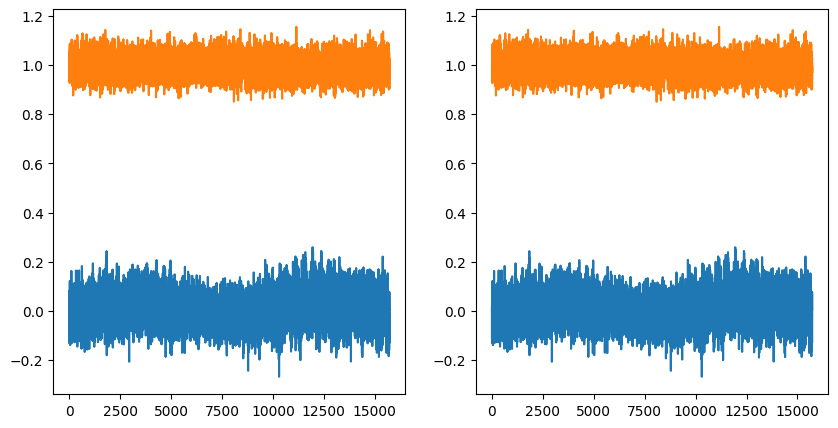

In [6]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(val_voxels.mean(0))
ax[0].plot(val_voxels.std(0))
ax[1].plot(val_voxels.mean(0))
ax[1].plot(val_voxels.std(0))

In [7]:
with torch.no_grad():
    preds = voxel2sd(val_voxels.float())
    all_lats = []
    for i in range(0, 300, 30):
        lats = autoenc.encode(2*torch.nn.functional.interpolate(
                                        val_images[i:i+30], (512, 512), mode='bilinear', align_corners=False, antialias=True
                                        )-1
                            ).latent_dist.mode() * 0.18215
        all_lats.append(lats)
    lats = torch.cat(all_lats)

In [8]:
with torch.no_grad():
    all_reconst = []
    for i in range(0, 300, 30):
        reconst = autoenc.decode(preds[i:i+30]/0.18215).sample
        all_reconst.append(reconst)
    reconst = torch.cat(all_reconst)

TypeError: expected Tensor as element 0 in argument 0, but got DecoderOutput

In [112]:
reconst=torch.cat([r.sample for r in all_reconst])

In [113]:
F.mse_loss(reconst, 2*F.interpolate(val_images, (512, 512), mode='bilinear', antialias=True)-1)

tensor(0.2671)

In [39]:
reconst=torch.cat([r.sample for r in all_reconst])
reconst = ((reconst/2 + 0.5).clamp(0,1)*255).byte()

In [44]:
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
ssim_loss = ssim(
    reconst, 
    (F.interpolate(val_images, (512, 512), mode='bilinear', antialias=True)*255).byte(), 
    data_range=255, size_average=True
)

In [49]:
val_images_512 = (F.interpolate(val_images, (512, 512), mode='bilinear', antialias=True)*255).byte()

In [54]:
from skimage.metrics import structural_similarity as ssim
ssims = []
for i in range(300):
    curr_ssim = ssim(val_images_512[i].permute(1,2,0).numpy(), reconst[i].permute(1,2,0).numpy(), data_range=255, channel_axis=2)
    ssims.append(curr_ssim)

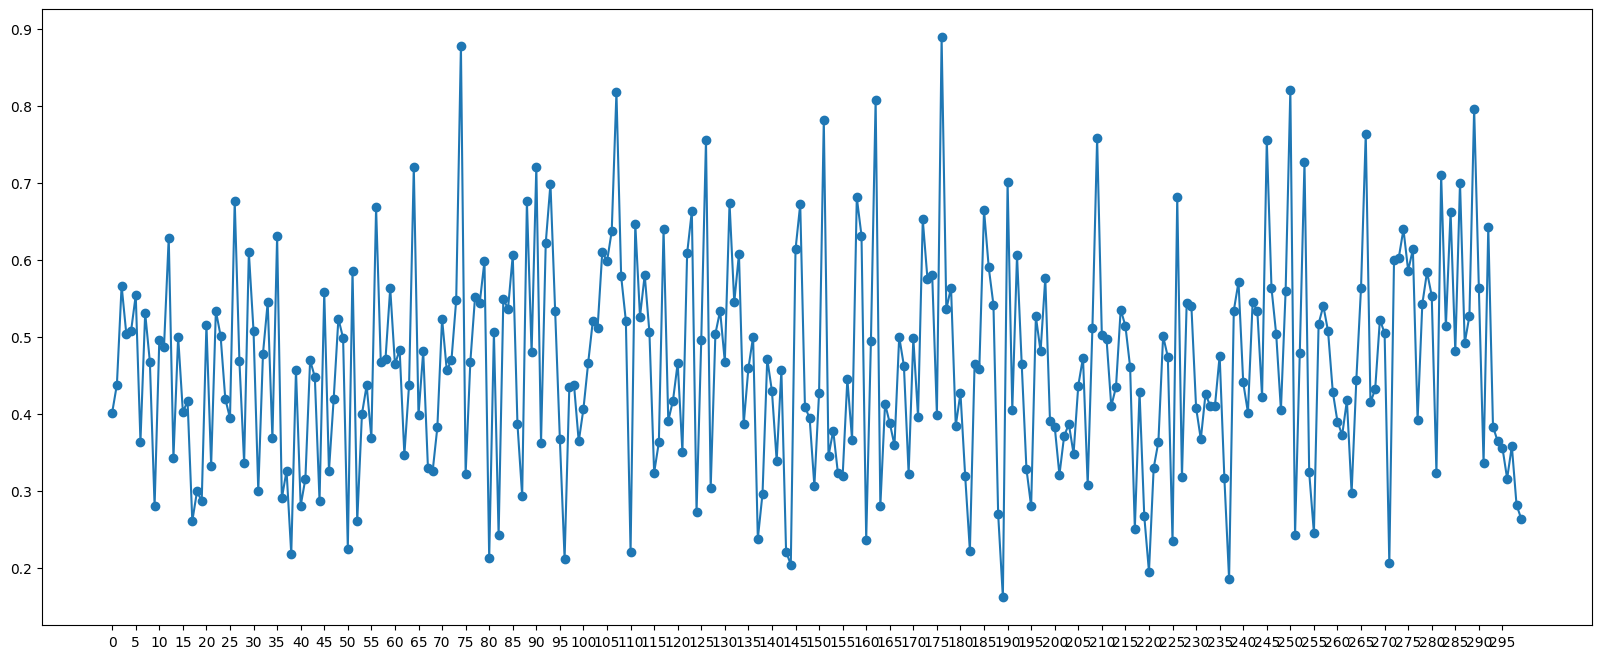

In [83]:
plt.figure(figsize=(20, 8))
plt.xticks(np.arange(0, len(ssims), 5))
plt.plot(ssims, 'o-')
plt.show()

In [90]:
ssims.argsort()

array([189, 237, 220, 144, 271,  96,  80,  38, 143, 110, 182,  50, 225,
       160, 137,  82, 251, 255, 217,  52,  17, 299, 219, 188, 124, 195,
         9, 163,  40, 298,  19,  44,  36,  87, 138, 263,  18,  31, 127,
       149, 207,  41, 296, 236, 227, 155, 181, 201,  75, 169, 281, 154,
       115, 254,  68,  46,  37, 194, 221,  67,  21,  28, 291, 141,  13,
       152,  62, 204, 121, 295, 297, 166,  91, 116, 222,   6,  99, 294,
       157,  95, 231,  34,  55, 202, 261, 153,  69, 200, 293, 179,  86,
       134, 203, 165, 260, 199, 118, 277, 148,  25, 171,  65, 175,  53,
         0, 241,  15, 248, 191, 100, 230, 147, 212, 234, 233, 164, 267,
        16, 119, 262,  47,  24, 244, 232, 180, 150, 218, 259, 140, 268,
        97, 213, 205,  54,  98,   1,  63, 240, 264, 156,  43,  71, 142,
        39, 184, 135, 216, 168, 193,  60, 183, 101, 120,  57,   8,  76,
       130,  27,  42,  72, 139,  58, 206, 224, 235,  32, 252,  89, 197,
        66, 285,  61,  11, 287, 161,  10, 125, 211, 170,  49,  1

In [92]:
ssims[64]

0.7210002877653131

In [87]:
ssims[107]

0.8179710135266447

In [63]:
ssims.mean()

0.4628162006093868

In [60]:
ssims = np.array(ssims)
ssims.argmin(), ssims.argmax()

(189, 176)

In [21]:
ssim_loss

tensor(0.5074)

In [45]:
ssim_loss

tensor(1.)

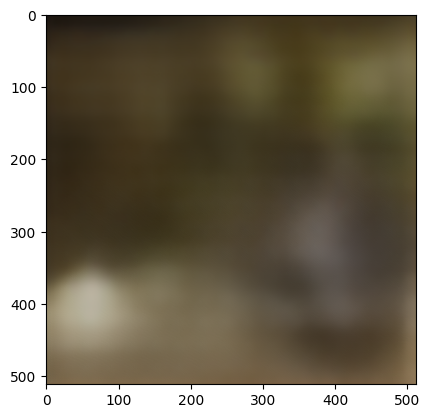

In [58]:
plt.imshow(reconst[189].permute(1,2,0))

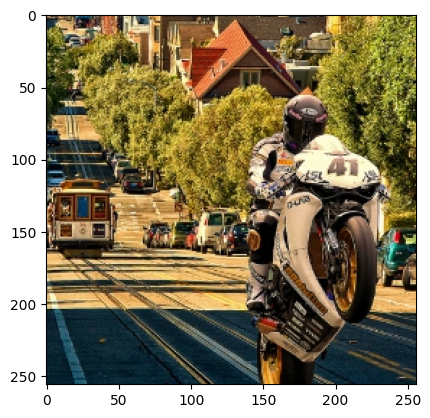

In [59]:
plt.imshow(val_images[189].permute(1,2,0))

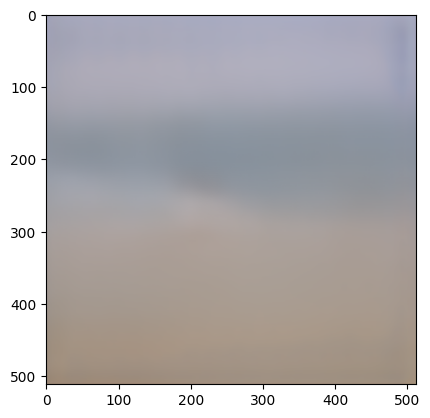

In [62]:
plt.imshow(reconst[176].permute(1,2,0))

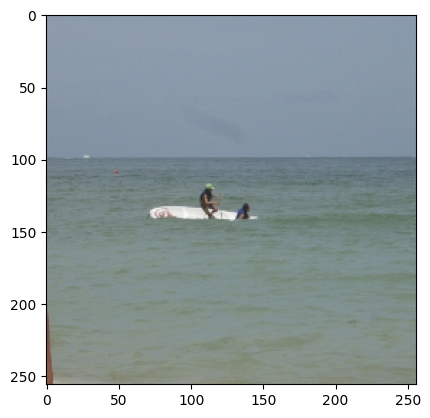

In [61]:
plt.imshow(val_images[176].permute(1,2,0))

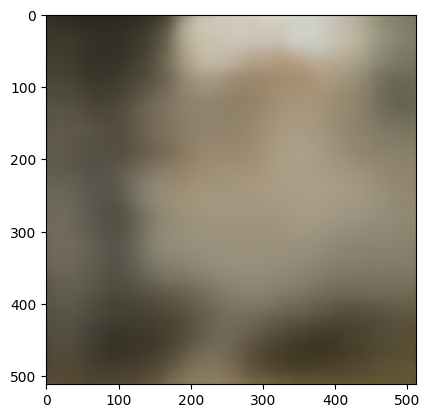

In [93]:
plt.imshow(reconst[64].permute(1,2,0))

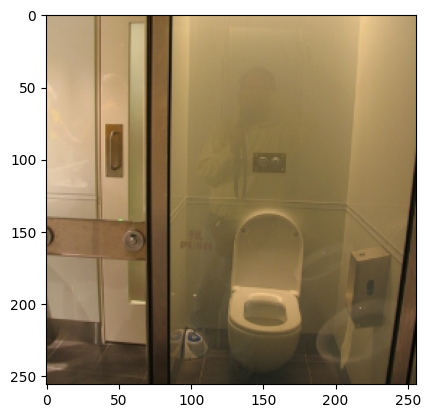

In [94]:
plt.imshow(val_images[64].permute(1,2,0))

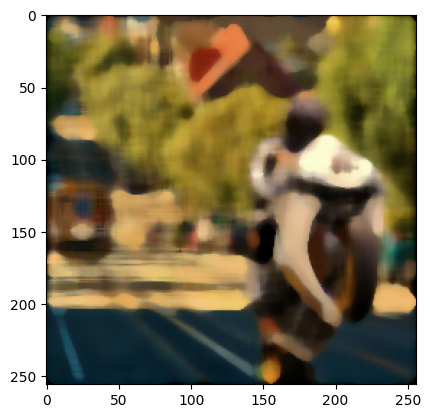

In [103]:
import kornia
# blurred = kornia.filters.bilateral_blur(val_images[189:190], (7,7), 0.1, (2,2))
blurred = kornia.filters.median_blur(val_images[189:190], (11,11))
plt.imshow(blurred[0].permute(1,2,0))

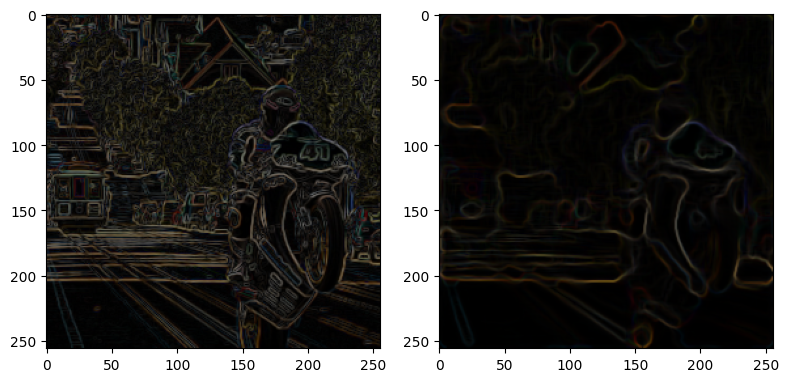

In [106]:
import kornia
# blurred = kornia.filters.bilateral_blur(val_images[189:190], (7,7), 0.1, (2,2))
blurred = kornia.filters.median_blur(val_images[189:190], (11,11))
edges_o = kornia.filters.sobel(val_images[189:190])
edges_b = kornia.filters.sobel(blurred)
fig,ax = plt.subplots(1,2,figsize=(8,10))
ax[0].imshow(edges_o[0].permute(1,2,0))
ax[1].imshow(edges_b[0].permute(1,2,0))
fig.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


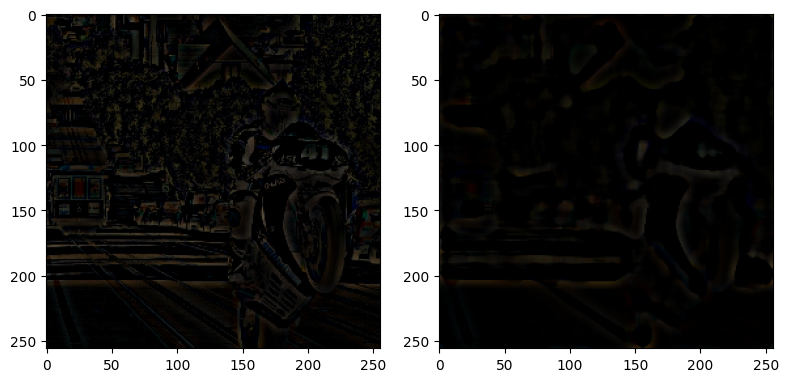

In [111]:
import kornia
# blurred = kornia.filters.bilateral_blur(val_images[189:190], (7,7), 0.1, (2,2))
blurred = kornia.filters.median_blur(val_images[189:190], (11,11))
edges_o = kornia.filters.laplacian(val_images[189:190], 13)
edges_b = kornia.filters.laplacian(blurred, 13)
fig,ax = plt.subplots(1,2,figsize=(8,10))
ax[0].imshow(edges_o[0].permute(1,2,0))
ax[1].imshow(edges_b[0].permute(1,2,0))
fig.tight_layout()

In [15]:
ms_ssim_val = ms_ssim( reconst, F.interpolate(val_images, (512, 512), mode='bilinear', antialias=True), data_range=1, size_average=True) #(N,)

In [16]:
ms_ssim_val

tensor(0.3187)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


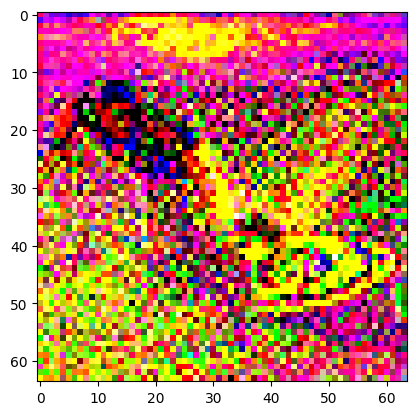

In [11]:
plt.imshow(lats[2].permute(1,2,0)[...,:3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


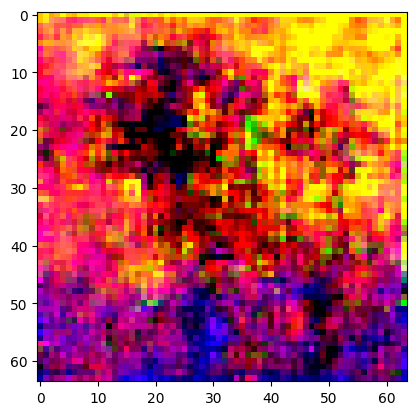

In [12]:
plt.imshow(preds[2].permute(1,2,0)[...,:3])

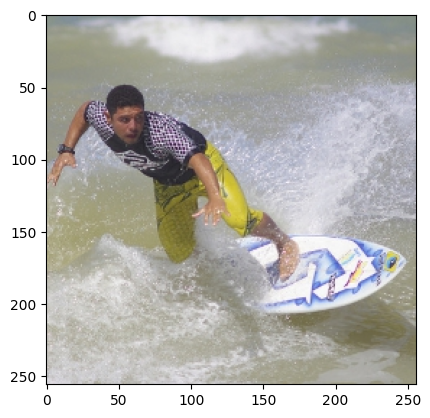

In [13]:
plt.imshow(val_images[2].permute(1,2,0))

In [14]:
with torch.no_grad():
    trn_preds = voxel2sd.cuda()(trn_voxels.float().cuda()).cpu()
    # reconst = autoenc.cuda().decode(preds/0.18215).sample.cpu()
    trn_lats = autoenc.cuda().encode(2*
                                 torch.nn.functional.interpolate(trn_images.cuda(), (512, 512), mode='bilinear', align_corners=False, antialias=True)-1
                                ).latent_dist.mode().cpu() * 0.18215

# pred_grid = make_grid(((reconst/2 + 0.5)*255).byte(), nrow=2)
# orig_grid = make_grid((images*255).byte(), nrow=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


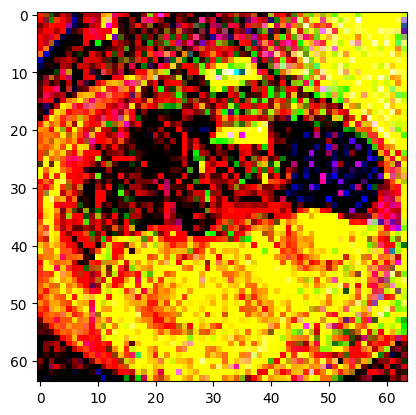

In [22]:
plt.imshow(trn_lats[3].permute(1,2,0)[...,:3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


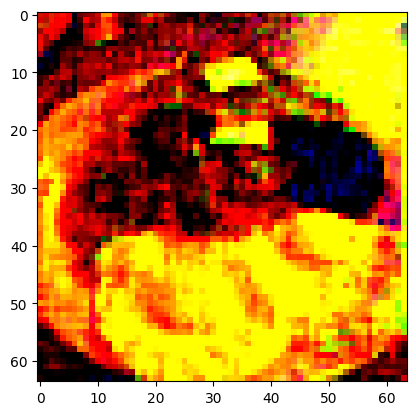

In [21]:
plt.imshow(trn_preds[3].permute(1,2,0)[...,:3])

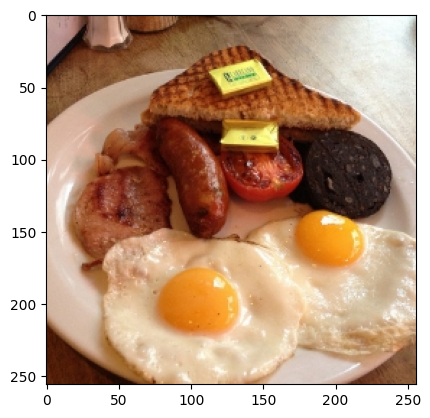

In [20]:
plt.imshow(trn_images[3].permute(1,2,0))